In [1]:
import pandas as pd
import torch
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 

print(dev)
 

cuda:0


In [2]:
dfTrain = pd.read_csv('train_datasettextssinglesizes1.csv')
dfTrain.head()

,info,label
0,This scketch contains 3 Total shapes 1 circles...,2
1,This scketch contains 4 Total shapes 2 circles...,0
2,This scketch contains 3 Total shapes 1 circles...,1
3,This scketch contains 3 Total shapes 1 circles...,4
4,This scketch contains 0 Total shapes The sketc...,1


In [3]:
dfTest = pd.read_csv('test_datasettextsinglesizess1.csv')
dfTest.head()

,info,label
0,This scketch contains 2 Total shapes 1 squares...,4
1,This scketch contains 3 Total shapes 2 circles...,2
2,This scketch contains 3 Total shapes 1 squares...,1
3,This scketch contains 2 Total shapes 1 circles...,3
4,This scketch contains 1 Total shapes 1 circles...,3


<Axes: xlabel='label'>

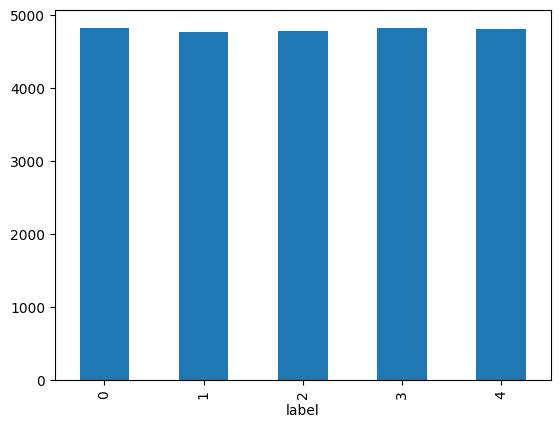

In [4]:
dfTrain.groupby(['label']).size().plot.bar()


<Axes: xlabel='label'>

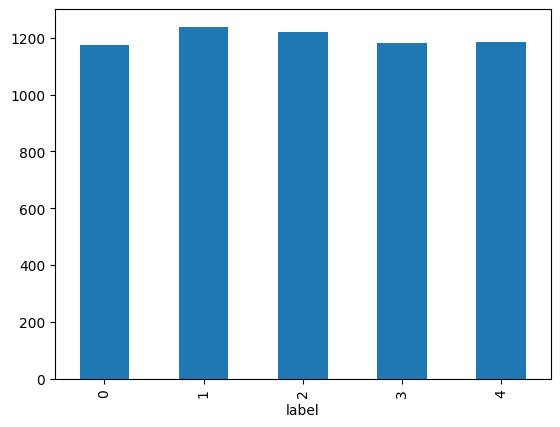

In [5]:
dfTest.groupby(['label']).size().plot.bar()

In [6]:
print(len(dfTest))
print(len(dfTrain))

6000
24000


In [7]:
from transformers import BertTokenizer

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [9]:
import numpy as np


In [10]:
labels2 = {0.0:0,
           1.0:1,
           2.0:2,
           3.0:3,
           4.0:4
           }

In [11]:
df_val = dfTest.iloc[0:3000]

df_Test = dfTest.iloc[3000:]

In [12]:
print(len(df_val))
print(len(df_Test))

3000
3000


In [13]:
df_val

,info,label
0,This scketch contains 2 Total shapes 1 squares...,4
1,This scketch contains 3 Total shapes 2 circles...,2
2,This scketch contains 3 Total shapes 1 squares...,1
3,This scketch contains 2 Total shapes 1 circles...,3
4,This scketch contains 1 Total shapes 1 circles...,3
...,...,...
2995,This scketch contains 3 Total shapes 1 circles...,0
2996,This scketch contains 4 Total shapes 4 squares...,2
2997,This scketch contains 2 Total shapes 1 lines a...,3
2998,This scketch contains 3 Total shapes 2 circles...,4


In [14]:
df_Test

,info,label
3000,This scketch contains 2 Total shapes 2 squares...,2
3001,This scketch contains 2 Total shapes 1 circles...,3
3002,This scketch contains 2 Total shapes 1 squares...,4
3003,This scketch contains 4 Total shapes 1 circles...,0
3004,This scketch contains 4 Total shapes 3 circles...,4
...,...,...
5995,This scketch contains 1 Total shapes 1 squares...,2
5996,This scketch contains 3 Total shapes 2 circles...,3
5997,This scketch contains 2 Total shapes 1 circles...,3
5998,This scketch contains 2 Total shapes 1 circles...,3


In [15]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels2[label] for label in df['label'].astype('float32')]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['info']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [16]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [26]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    print(device)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, dfTrain, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda


100%|██████████| 12000/12000 [59:52<00:00,  3.34it/s]


Epochs: 1 | Train Loss:  0.227                 | Train Accuracy:  0.861                 | Val Loss:  0.142                 | Val Accuracy:  0.910


100%|██████████| 12000/12000 [1:00:09<00:00,  3.32it/s]


Epochs: 2 | Train Loss:  0.145                 | Train Accuracy:  0.911                 | Val Loss:  0.137                 | Val Accuracy:  0.915


100%|██████████| 12000/12000 [1:00:18<00:00,  3.32it/s]


Epochs: 3 | Train Loss:  0.134                 | Train Accuracy:  0.916                 | Val Loss:  0.135                 | Val Accuracy:  0.910


100%|██████████| 12000/12000 [1:00:24<00:00,  3.31it/s]


Epochs: 4 | Train Loss:  0.128                 | Train Accuracy:  0.918                 | Val Loss:  0.127                 | Val Accuracy:  0.915


100%|██████████| 12000/12000 [1:00:33<00:00,  3.30it/s]


Epochs: 5 | Train Loss:  0.123                 | Train Accuracy:  0.920                 | Val Loss:  0.125                 | Val Accuracy:  0.920


In [28]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_Test)

Test Accuracy:  0.915


In [31]:
torch.save(model.state_dict(), 'BERTPyTorchModel15EPOCHS')